In [1]:
import scanpy as sc
import scvi
import numpy as np
import pandas as pd
import numpy.random as random
import scipy
import anndata
import matplotlib.pyplot as plt

Global seed set to 0


In [2]:
import torch
device = torch.device("cuda")

In [3]:
query_adata = sc.read('/nfs/team205/heart/anndata_objects/Foetal/RNA_foetal_raw_rmdbl_rmdblcls_celltype-annotated.h5ad')

In [4]:
query_adata

AnnData object with n_obs × n_vars = 82701 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', '_scvi_batch', '_scvi_labels', 'leiden_scVI', 'cell_type', 'doublet_cls'
    var: 'gene_name_scRNA-0', 'gene_name_multiome-1'
    uns: 'cell_type_colors', 'leiden_scVI_colors'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_continuous', 'latent_gene_encoding'
    obsp: 'connectivities', 'distances'

In [5]:
def _verify_counts(adata):
    return(all([not (i%1) for i in adata.X[0,:].toarray()[0]]))

if not _verify_counts(query_adata):
    raise ValueError('`query_adata.X` does not contain raw counts.')
if not query_adata.var_names.str.startswith("ENS").all():
    raise ValueError('`query_adata.var_names` are not Ensembl geneIDs. Please convert')

In [6]:
## Change var_names to ensemblIDs
# query_adata.var['gene_names'] = query_adata.var_names.values.copy()
# query_adata.var_names = query_adata.var['gene_ids'].values

In [7]:
query_adata.var_names

Index(['ENSG00000243485', 'ENSG00000237613', 'ENSG00000186092',
       'ENSG00000238009', 'ENSG00000239945', 'ENSG00000239906',
       'ENSG00000241860', 'ENSG00000241599', 'ENSG00000286448',
       'ENSG00000236601',
       ...
       'ENSG00000274175', 'ENSG00000275869', 'ENSG00000273554',
       'ENSG00000278782', 'ENSG00000277761', 'ENSG00000277836',
       'ENSG00000278633', 'ENSG00000276017', 'ENSG00000278817',
       'ENSG00000277196'],
      dtype='object', name='id', length=36601)

In [8]:
model_dir = '/nfs/team205/heart/anndata_objects/6region-SAN/scVI/models/RNA_adult-6reg-SAN_global_rmdbl/'

In [9]:
query_adata.obs["bbk"] = 'adult'

In [10]:
var_names_model = pd.read_csv(model_dir + "var_names.csv", header=None)[0].values
is_in_query_var = pd.Series(var_names_model).isin(query_adata.var_names)
n_genes = len(var_names_model[~is_in_query_var])
print("% or genes missing from query: {p}%".format(p=np.round((n_genes/len(var_names_model))*100,2)))

% or genes missing from query: 0.0%


In [11]:
n_genes

0

In [12]:
query_adata.X.max()

11913.0

In [13]:
query_adata.layers.keys()

KeysView(Layers with keys: )

In [14]:
query_adata

AnnData object with n_obs × n_vars = 82701 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', '_scvi_batch', '_scvi_labels', 'leiden_scVI', 'cell_type', 'doublet_cls', 'bbk'
    var: 'gene_name_scRNA-0', 'gene_name_multiome-1'
    uns: 'cell_type_colors', 'leiden_scVI_colors'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_continuous', 'latent_gene_encoding'
    obsp: 'connectivities', 'distances'

In [15]:
query_adata.layers["counts"] = query_adata.X.copy()

In [16]:
## Load new model with the query data
vae_q = scvi.model.SCVI.load_query_data(
    query_adata,
    model_dir,
    inplace_subset_query_vars=True
)

INFO     Using data from adata.layers["counts"]                                              


/nfs/team205/dm19/miniconda3/envs/scarches/lib/python3.7/site-packages/scvi/model/base/_archesmixin.py:96: UserWarning: Query integration should be performed using models trained with version >= 0.8
  "Query integration should be performed using models trained with version >= 0.8"
/nfs/team205/dm19/miniconda3/envs/scarches/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


INFO     Registered keys:['X', 'batch_indices', 'labels', 'cont_covs']                       
INFO     Successfully registered anndata object containing 82701 cells, 3028 vars, 35        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 3 extra continuous covariates.                                                  


In [17]:
vae_q = scvi.model.SCVI.load('vae_query_model', query_adata, use_gpu=True)

INFO     Using data from adata.layers["counts"]                                              
INFO     Registered keys:['X', 'batch_indices', 'labels', 'cont_covs']                       
INFO     Successfully registered anndata object containing 82701 cells, 3028 vars, 35        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 3 extra continuous covariates.                                                  


In [18]:
query_adata.obsm["X_scvi"] = vae_q.get_latent_representation()

In [19]:
sc.pp.neighbors(query_adata, use_rep="X_scvi")
sc.tl.leiden(query_adata)
sc.tl.umap(query_adata)

In [20]:
query_adata

AnnData object with n_obs × n_vars = 82701 × 3028
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', '_scvi_batch', '_scvi_labels', 'leiden_scVI', 'cell_type', 'doublet_cls', 'bbk', 'leiden'
    var: 'gene_name_scRNA-0', 'gene_name_multiome-1'
    uns: 'cell_type_colors', 'leiden_scVI_colors', '_scvi', 'neighbors', 'leiden', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_continuous', 'latent_gene_encoding', 'X_scvi'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [21]:
sc.pp.normalize_per_cell(query_adata)
sc.pp.log1p(query_adata)

In [22]:
ref_adata = sc.read('/nfs/team205/heart/anndata_objects/6region-SAN/RNA_adult-6reg-SAN_raw_rmdbl_rmdblcls_cellstate-annotated.h5ad')

In [23]:
ref_adata

AnnData object with n_obs × n_vars = 673262 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'donor_predicted', 'donor_physical', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_states_HCAv1', 'cell_states_scNym', 'cell_states_scNym_confidence', 'cell_state'
    var: 'gene_name_scRNA-0', 'gene_name_snRNA-1', 'gene_name_multiome-2'
    uns: 'cell_or_nuclei_colors', 'cell_state_colors', 'cell_states_HCAv1_colors', 'cell_states_scNym_colors', 'cell_type_colors', 'donor_colors', 'kit_10x_colors', 'leiden_scVI_colors', 'region_colors'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_continuous', 'latent_gene_encoding'
    obsp: 'connectivities', 'distances'

In [24]:
ref_adata.layers["counts"] = ref_adata.X.copy()

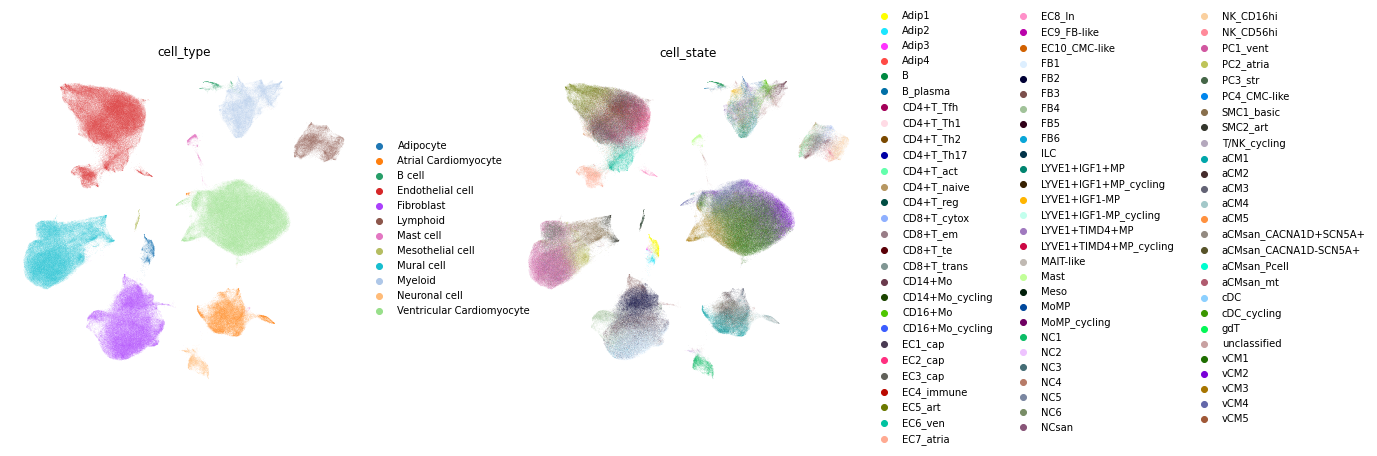

In [25]:
plt.rcParams['figure.figsize'] = [6,6]
sc.pl.umap(
    ref_adata,
    color=["cell_type", "cell_state"],
    frameon=False,
    wspace=0.3
)

/nfs/team205/dm19/miniconda3/envs/scarches/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'bbk' as categorical


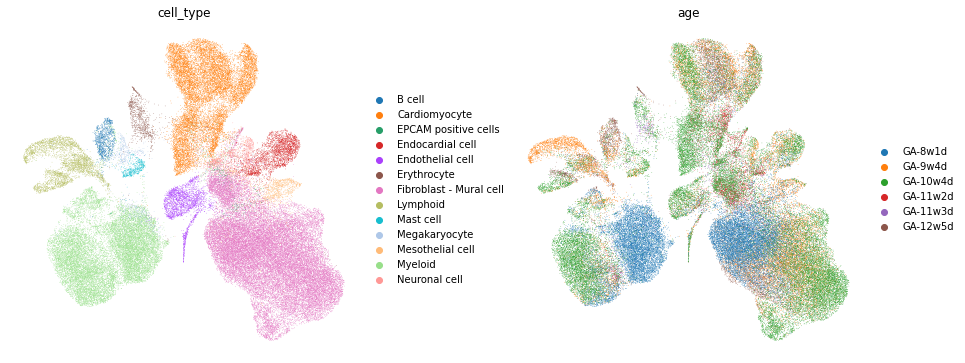

In [26]:
plt.rcParams['figure.figsize'] = [6,6]
sc.pl.umap(
    query_adata,
    color=["cell_type", "age"],
    frameon=False,
    wspace=0.3
)

In [27]:
sc.pp.subsample(ref_adata, fraction=0.2)

In [28]:
## Convert var_names to ensembl IDs
ref_adata.var_names = ref_adata.var.index
query_adata.var_names = query_adata.var.index

In [29]:
ref_adata.var_names

Index(['ENSG00000243485', 'ENSG00000237613', 'ENSG00000186092',
       'ENSG00000238009', 'ENSG00000239945', 'ENSG00000239906',
       'ENSG00000241599', 'ENSG00000236601', 'ENSG00000284733',
       'ENSG00000235146',
       ...
       'ENSG00000277196', 'ENSG00000277630', 'ENSG00000278384',
       'ENSG00000278633', 'ENSG00000276345', 'ENSG00000277856',
       'ENSG00000275063', 'ENSG00000271254', 'ENSG00000277475',
       'ENSG00000268674'],
      dtype='object', length=32732)

In [30]:
query_adata.var_names

Index(['ENSG00000272512', 'ENSG00000188290', 'ENSG00000187608',
       'ENSG00000188157', 'ENSG00000162571', 'ENSG00000186891',
       'ENSG00000186827', 'ENSG00000184163', 'ENSG00000179403',
       'ENSG00000197921',
       ...
       'ENSG00000198763', 'ENSG00000198804', 'ENSG00000198712',
       'ENSG00000228253', 'ENSG00000198899', 'ENSG00000198938',
       'ENSG00000198840', 'ENSG00000198886', 'ENSG00000198786',
       'ENSG00000198727'],
      dtype='object', name='id', length=3028)

In [31]:
np.isnan(ref_adata.obsm['X_scVI']).sum()

0

In [32]:
np.isnan(query_adata.obsm['X_scVI']).sum()

0

In [33]:
## Merge
concat_adata = anndata.concat([ref_adata, query_adata], axis=0,
                              label="dataset", keys=["reference", "query"],
                              join="outer", merge="unique", uns_merge="unique")
concat_adata.obs_names = concat_adata.obs_names + "-" + concat_adata.obs["dataset"].astype("str")

In [34]:
concat_adata

AnnData object with n_obs × n_vars = 217353 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'donor_predicted', 'donor_physical', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_states_HCAv1', 'cell_states_scNym', 'cell_states_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', '_scvi_batch', '_scvi_labels', 'doublet_cls', 'bbk', 'leiden', 'n_counts', 'dataset'
    var: 'gene_name_snRNA-1', 'gene_name_multiome-2', 'gene_name_multiome-1'
    uns: 'cell_or_nuclei_colors', 'cell_state_colors', 'cell_states_HCAv1_colors', 'cell_states_scNym_colors', 'donor_colors', 'kit_10x_colors', 'region_colors', '_s

In [35]:
np.isnan(concat_adata.layers['counts'].toarray()).sum()

0

In [36]:
np.isnan(concat_adata.obsm['X_scVI']).sum()

0

In [37]:
np.isnan(concat_adata.X.toarray()).sum()

0

In [38]:
concat_adata.X.max()

28310.0

In [39]:
metadata = concat_adata.obs.copy()

In [40]:
concat_adata

AnnData object with n_obs × n_vars = 217353 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'donor_predicted', 'donor_physical', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_states_HCAv1', 'cell_states_scNym', 'cell_states_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', '_scvi_batch', '_scvi_labels', 'doublet_cls', 'bbk', 'leiden', 'n_counts', 'dataset'
    var: 'gene_name_snRNA-1', 'gene_name_multiome-2', 'gene_name_multiome-1'
    uns: 'cell_or_nuclei_colors', 'cell_state_colors', 'cell_states_HCAv1_colors', 'cell_states_scNym_colors', 'donor_colors', 'kit_10x_colors', 'region_colors', '_s

In [41]:
## Compute UMAP
sc.pp.neighbors(concat_adata, n_neighbors=30, use_rep="X_scVI")
sc.tl.umap(concat_adata, min_dist = 0.01, spread = 2)

/nfs/team205/dm19/miniconda3/envs/scarches/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'sangerID' as categorical
/nfs/team205/dm19/miniconda3/envs/scarches/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'combinedID' as categorical
/nfs/team205/dm19/miniconda3/envs/scarches/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is depre

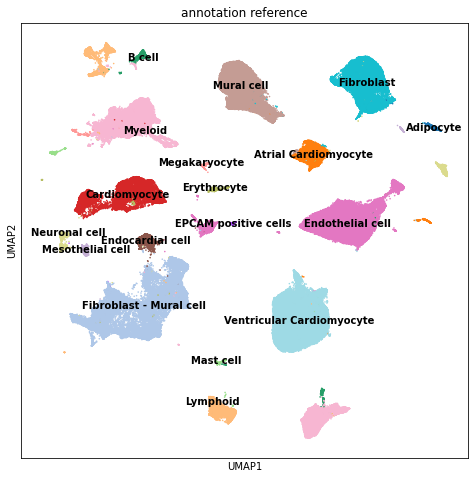

In [42]:
plt.rcParams['figure.figsize'] = [8,8]
sc.pl.umap(concat_adata, color=['cell_type'], size=10, 
           title=['annotation reference', 'annotation query'], legend_loc='on data')

In [43]:
import sys
sys.path.append('scArches_utils/')
import map_query_utils

In [44]:
concat_adata

AnnData object with n_obs × n_vars = 217353 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'donor_predicted', 'donor_physical', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_states_HCAv1', 'cell_states_scNym', 'cell_states_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', '_scvi_batch', '_scvi_labels', 'doublet_cls', 'bbk', 'leiden', 'n_counts', 'dataset'
    var: 'gene_name_snRNA-1', 'gene_name_multiome-2', 'gene_name_multiome-1'
    uns: 'cell_or_nuclei_colors', 'cell_state_colors', 'cell_states_HCAv1_colors', 'cell_states_scNym_colors', 'donor_colors', 'kit_10x_colors', 'region_colors', '_s

In [45]:
concat_adata.obsm["X_scvi"] = concat_adata.obsm['X_scVI'].copy()
concat_adata.obs['cell_type_reference'] = concat_adata.obs.cell_type.astype(str).copy()
concat_adata.obs.loc[concat_adata.obs.dataset == "query","cell_type_reference"] = np.nan

In [46]:
concat_adata.obs['cell_type_reference'] 

HCAHeart7888925_CCGGTAGGTCAAAGCG-1-reference                             Endothelial cell
HCAHeart7844004_TCTTCGGAGCCCAGCT-1-reference                             Endothelial cell
HCAHeart7702879_ACCTTTATCTTACCTA-1-reference                                   Mural cell
H0020_apex_GTGTGGCAGTTCCATG-reference                           Ventricular Cardiomyocyte
HCAHeart8102867_GTCGAATGTCGTCTCT-reference                               Endothelial cell
                                                                          ...            
BHF_F_Hea11064672_BHF_F_Hea11031825_GTTAAGTGTTTGTCTA-1-query                          NaN
BHF_F_Hea11064672_BHF_F_Hea11031825_CAGGGTGAGGTCCGTA-1-query                          NaN
BHF_F_Hea11064672_BHF_F_Hea11031825_GGAAGCTAGCATGTTA-1-query                          NaN
BHF_F_Hea11064672_BHF_F_Hea11031825_ACTGAATGTGTGTGGT-1-query                          NaN
BHF_F_Hea11064672_BHF_F_Hea11031825_AGTGCGGAGTAGCGCC-1-query                          NaN
Name: cell

In [47]:
map_query_utils.predict_label2(concat_adata, anno_col='cell_type_reference', min_score=0.5)

685.5204029083252


In [48]:
n_cells = concat_adata.obs['predicted_anno'].value_counts()
n_cells

Ventricular Cardiomyocyte    31239
Endothelial cell             25040
Mural cell                   13148
low_confidence               11332
Fibroblast                    1787
Myeloid                        155
Name: predicted_anno, dtype: int64

In [49]:
## Exclude low abundance predictions
low_ab_predictions = n_cells.index[n_cells < 10]
concat_adata.obs.loc[concat_adata.obs['predicted_anno'].isin(low_ab_predictions), 'predicted_anno'] = 'low_confidence'

/nfs/team205/dm19/miniconda3/envs/scarches/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type_reference' as categorical
/nfs/team205/dm19/miniconda3/envs/scarches/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_anno' as categorical
/nfs/team205/dm19/miniconda3/envs/scarches/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_cate

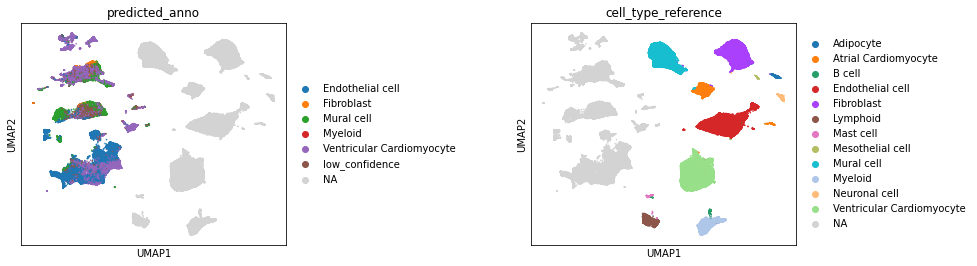

In [50]:
plt.rcParams['figure.figsize'] = [4,4]
sc.pl.umap(concat_adata, color=['predicted_anno', 'cell_type_reference'], size=10, wspace=0.75)

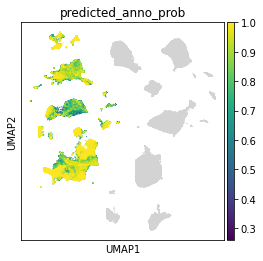

In [51]:
sc.pl.umap(concat_adata, color=['predicted_anno_prob'], size=5, wspace=1.0)

In [52]:
query_adata.obs['predicted_anno'] = concat_adata.obs[concat_adata.obs['dataset']=='query']['predicted_anno'].values

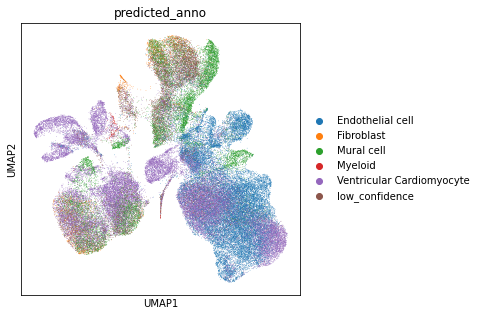

In [53]:
plt.rcParams['figure.figsize'] = [5,5]
sc.pl.umap(query_adata, color=['predicted_anno'])

In [54]:
concat_adata.write('/nfs/team205/heart/scarches/adult_and_foetal_subsampled.h5ad')